# Detección de inicio de inspiración


Importamos las librerías


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig

Determinamos el path al archivo de datos


In [2]:
path = './Mini TP 15_09_22-08_47_01 Signals.txt'

Cargamos los datos y vemos como están estructurados para después seleccionar los datos que nos interesan y re-acomodarlos


In [3]:
txt = pd.read_csv(path)
txt.head(8)

,FluxView - FluxMed acquisition system
0,Signal file
1,Serial Number\t:
2,SW version:\t1.20h-OX-CO2\tFile version:\t1.13
3,Sampling rate:\t256 Hz
4,Time\tFlow\tVolume\tPaw\tPes\tPtpulm\tPga\tPtd...
5,0.00390625\t0.0\t0\t0.0\t0.0\t0.0\t0.1\t0.1\t0...
6,0.00781250\t0.0\t0\t0.0\t0.0\t0.0\t0.3\t0.3\t0...
7,0.01171875\t0.0\t0\t0.0\t0.0\t0.0\t0.1\t0.1\t0...


Vemos que:

- fila 3 tiene el sampling rate
- fila 4 tiene los nombres de las columnas
- fila 5 en adelante son los datos


## Guardamos el sample rate


Lo tomamos de la fila 3, separamos la cadena y nos quedamos con el numero, que es un string, lo convertimos a int y lo guardamos en una variable


In [4]:
sample_rate = txt.iloc[3, 0].split('\t')[1].split(' ')[0]
sample_rate = int(sample_rate)

sample_rate

256

## Dataframe con los datos

Primero tomamos los nombres de las columnas, que están en la fila 4, y los guardamos en una lista


In [5]:
headers = txt.iloc[4,0].split('\t')
headers = headers[:-1]
headers


['Time', 'Flow', 'Volume', 'Paw', 'Pes', 'Ptpulm', 'Pga', 'Ptdiaf', 'CO2']

Ahora tomamos los datos, que están en las filas 5 en adelante, y los guardamos en un dataframe al que le asignamos los nombres de las columnas ya guardadas


In [6]:
data = txt.iloc[5:, 0].str.split('\t', expand=True)
data.drop(data.columns[[-1]], axis=1, inplace=True)
# change the headers of the dataframe
data.columns = headers
# eliminar los indices de las filas
data = data.reset_index(drop=True)
data

,Time,Flow,Volume,Paw,Pes,Ptpulm,Pga,Ptdiaf,CO2
0,0.00390625,0.0,0,0.0,0.0,0.0,0.1,0.1,0.0
1,0.00781250,0.0,0,0.0,0.0,0.0,0.3,0.3,0.0
2,0.01171875,0.0,0,0.0,0.0,0.0,0.1,0.1,0.0
3,0.01562500,0.0,0,-0.1,0.0,-0.1,0.1,0.1,0.0
4,0.01953125,0.0,0,0.0,0.0,0.0,0.1,0.1,0.0
...,...,...,...,...,...,...,...,...,...
818662,3197.90234400,-45.6,-19264,10.0,5.2,4.8,5.5,0.3,1.9
818663,3197.90625000,-45.0,-19267,10.0,5.0,5.0,5.5,0.5,2.1
818664,3197.91015600,-44.4,-19270,10.0,5.2,4.8,5.5,0.3,2.4
818665,3197.91406300,-43.9,-19273,10.1,5.2,4.9,5.4,0.2,2.6


In [7]:
# make the data numeric
data = data.apply(pd.to_numeric)

## Graficamos las curvas

Vamos a gráficar la curva de flujo, volumen y presion de los datos obtenidos


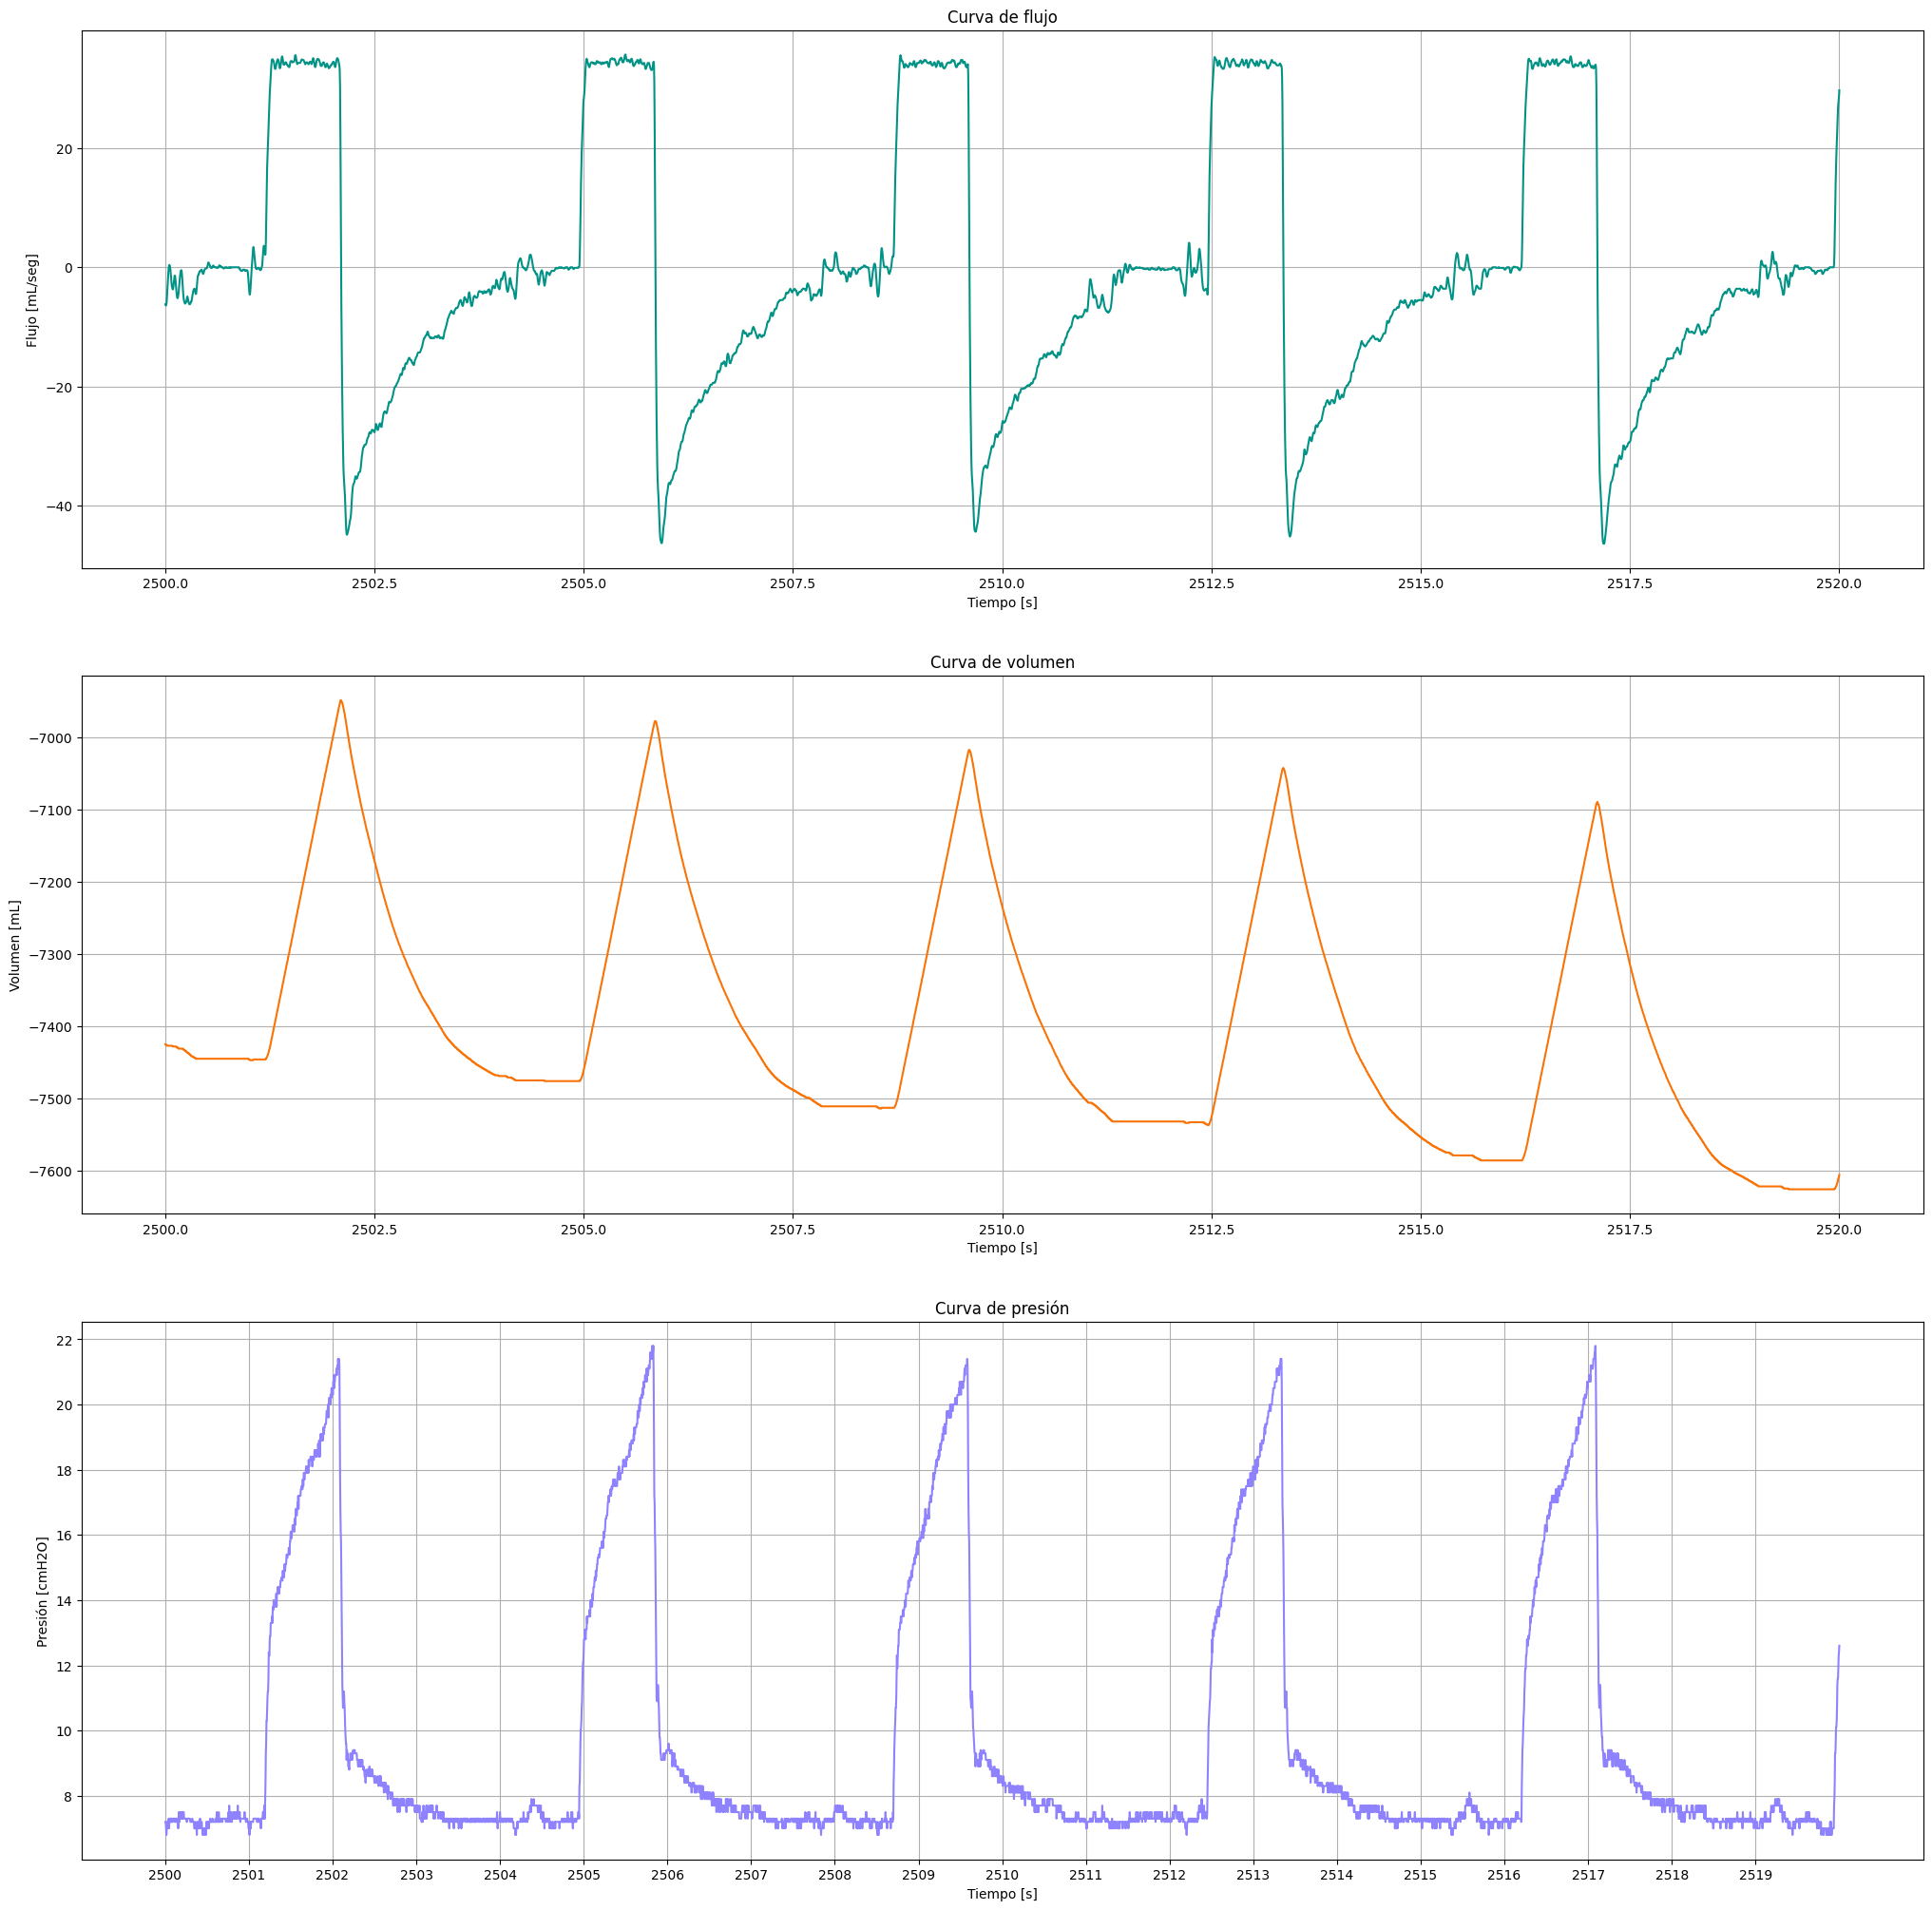

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(25, 25))

transient = 2500 # seconds
transient_number = transient * sample_rate
seconds = 20 # seconds
sample_number = seconds * sample_rate


### CURVA DE FLUJO ###
ax[0].plot(data['Time'][transient_number:transient_number + sample_number],
           data['Flow'][transient_number:transient_number + sample_number],
           color='xkcd:teal')

ax[0].set_title('Curva de flujo')
ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Flujo [mL/seg]')
ax[0].grid(True)


### CURVA DE VOLUMEN ###
ax[1].plot(data['Time'][transient_number:transient_number + sample_number],
           data['Volume'][transient_number:transient_number + sample_number],
           color='xkcd:orange')

ax[1].set_title('Curva de volumen')
ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Volumen [mL]')
ax[1].grid(True)

### CURVA DE PRESIÓN ###
ax[2].plot(data['Time'][transient_number:transient_number + sample_number],
           data['Paw'][transient_number:transient_number + sample_number],
           color='xkcd:periwinkle')
ax[2].set_title('Curva de presión')
ax[2].set_xlabel('Tiempo [s]')
ax[2].set_ylabel('Presión [cmH2O]')
ax[2].set_xticks(np.arange(transient, transient + seconds, 1))
ax[2].grid(True)


plt.show()


## Algoritmo basado en el volumen


Para comprender el algoritmo, es importante tener en cuenta que la frecuencia respiratoria normal para un adulto en reposo es de 8 a 16 respiraciones por minuto. Por lo tanto, en promedio, no debería haber respiraciones más rápidas que una respiración cada 3.75 segundos. Para el algoritmo, se considera un tiempo mínimo de 1 segundo entre respiraciones, teniendo en cuenta que está siendo guiado por el respirador y que no se alejará de los valores fisiológicos o normales.


In [9]:
def inicio_inspiracion(volume):
    # Criterio: que la derivada (o sea el flujo) sea mayor que threshold_flow por mas de threshold_time segundos
    threshold_flow = 0.01  # [L/s]
    threshold_time = 0.01 # [s]

    calculated_flow = np.diff(volume)  # [L/s]
    marcador = np.zeros(len(calculated_flow))

    for m in range(len(calculated_flow)):
        if calculated_flow[m] >= threshold_flow:
            # si las proximas threshold_time*sample_rate mediciones son mayores a threshold_flow y las anteriores son menores al threshold_flow, entonces es inspiracion
            if np.all(calculated_flow[m:m + int(threshold_time * sample_rate)]
                      > threshold_flow) and np.all(
                          calculated_flow[m - int(threshold_time * sample_rate
                                                  ):m-1] < threshold_flow):
                marcador[m] = 1
        else:
            marcador[m] = 0

    time_insp = np.argwhere(marcador == 1.0) / sample_rate  # tiempo en que empieza la inspiracion
    time_insp = time_insp.flatten()
    
    time_diff = np.diff(time_insp)
    min_time_diff = 1  # [s]
    time_insp = np.delete(time_insp, np.argwhere(time_diff < min_time_diff) + 1) # eliminamos la segunda 'inspiracion' por eso el +1
    

    return time_insp

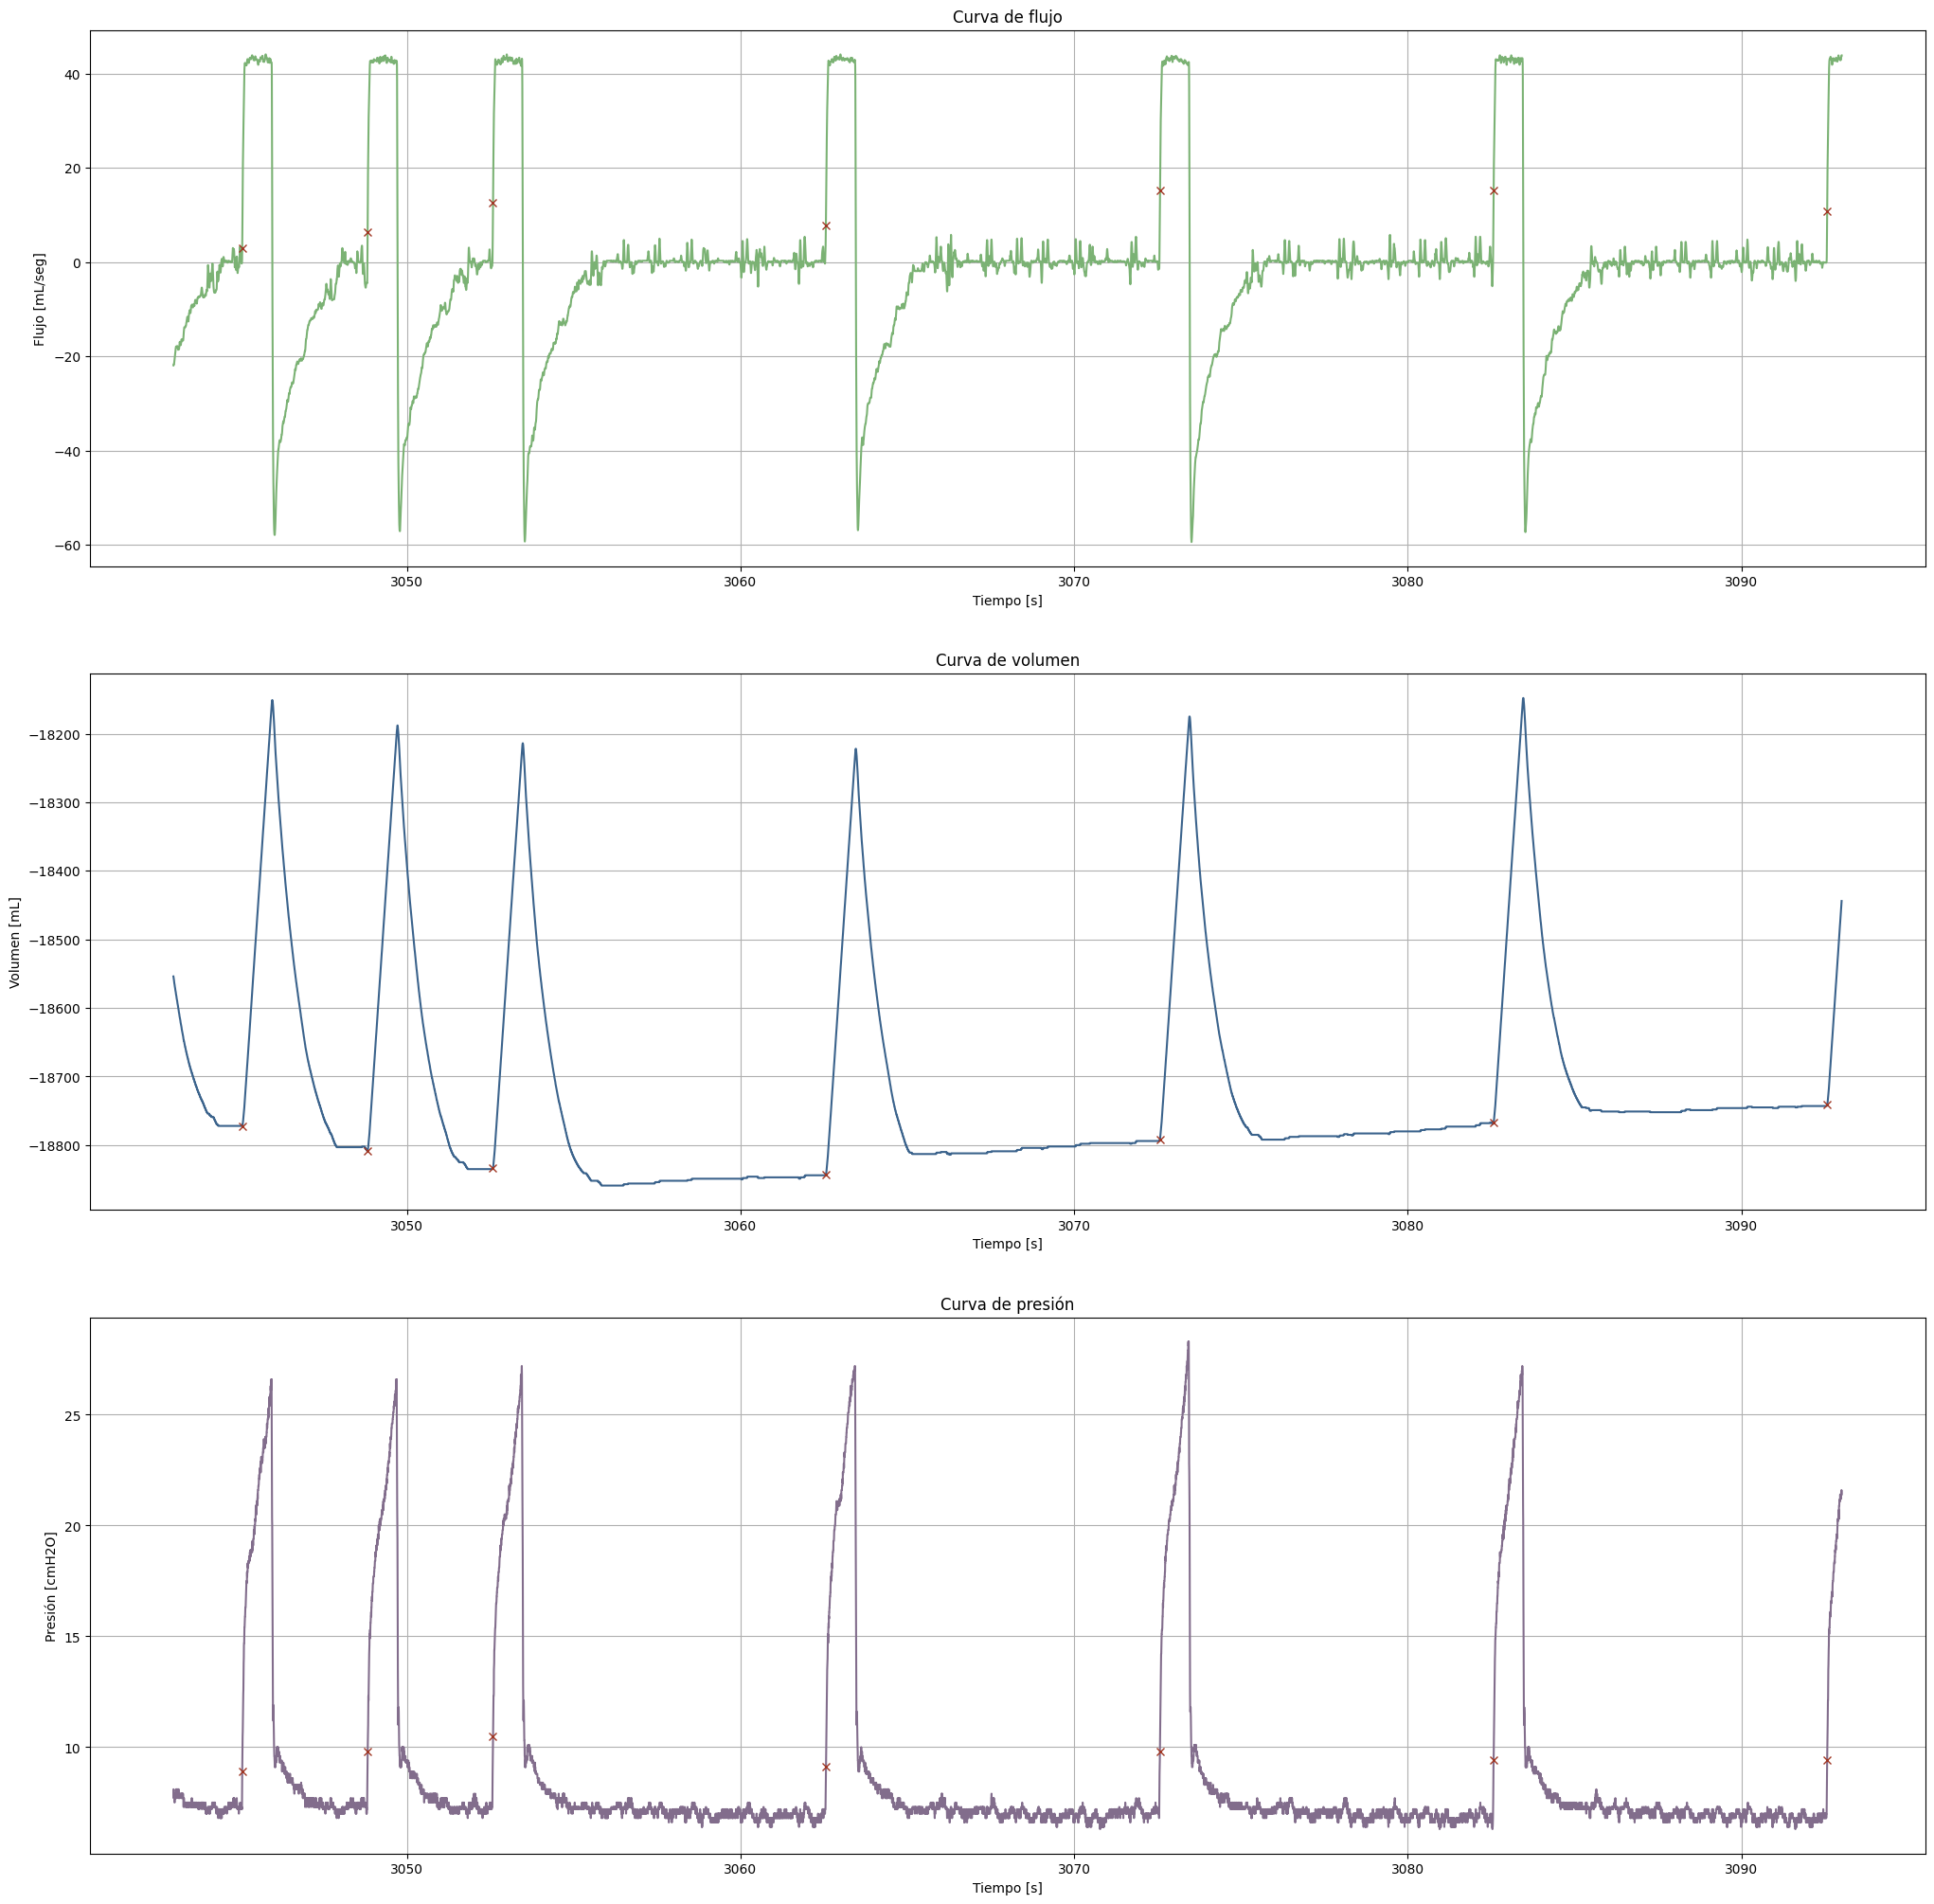

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(25, 25))

transient = 3043 # seconds
transient_number = transient * sample_rate
seconds = 50 # seconds
sample_number = seconds * sample_rate


### CURVA DE FLUJO ###
ax[0].plot(data['Time'][transient_number:transient_number + sample_number],
           data['Flow'][transient_number:transient_number + sample_number],
           color='xkcd:faded green')

ax[0].set_title('Curva de flujo')
ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Flujo [mL/seg]')
ax[0].grid(True)
for elem in inicio_inspiracion(data['Volume'][transient*sample_rate:transient*sample_rate+seconds*sample_rate]):
    ax[0].plot(elem+transient, data['Flow'][transient*sample_rate+int(elem*sample_rate)], 'x', color='xkcd:brick')

### CURVA DE VOLUMEN ###
ax[1].plot(data['Time'][transient_number:transient_number + sample_number],
           data['Volume'][transient_number:transient_number + sample_number],
           color='xkcd:denim')

ax[1].set_title('Curva de volumen')
ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Volumen [mL]')
ax[1].grid(True)
for elem in inicio_inspiracion(data['Volume'][transient*sample_rate:transient*sample_rate+seconds*sample_rate]):
    ax[1].plot(elem+transient, data['Volume'][transient*sample_rate+int(elem*sample_rate)], 'x', color='xkcd:brick')


### CURVA DE PRESIÓN ###
ax[2].plot(data['Time'][transient_number:transient_number + sample_number],
           data['Paw'][transient_number:transient_number + sample_number],
           color='xkcd:grey purple')
ax[2].set_title('Curva de presión')
ax[2].set_xlabel('Tiempo [s]')
ax[2].set_ylabel('Presión [cmH2O]')
ax[2].grid(True)
for elem in inicio_inspiracion(data['Volume'][transient*sample_rate:transient*sample_rate+seconds*sample_rate]):
    ax[2].plot(elem+transient, data['Paw'][transient*sample_rate+int(elem*sample_rate)], 'x', color='xkcd:brick')

plt.show()